In [30]:
import numpy as np
import pandas as pd
import google.generativeai as genai
import google.ai.generativelanguage as glm
import wizmap
import umap
import matplotlib.pyplot as plt

from json import load, dump

SEED = 2024

## Generate Embeddings for the Awesome Prompts

In [2]:
API_KEY = input('API key: ')
genai.configure(api_key=API_KEY)

In [65]:
df = pd.read_csv('./data/awesome-prompts.csv')
awesome_prompts = df['prompt']

In [67]:
awesome_embeddings = []
for p in awesome_prompts:
    embedding_point = genai.generate_embeddings(
        model="models/embedding-gecko-001", text=p
    )
    awesome_embeddings.append(embedding_point)

In [71]:
awesome_embeddings = [i['embedding'] for i in awesome_embeddings]

In [88]:
len(awesome_embeddings)

153

## Load Embeddings for AI Incidents

In [18]:
reports = load(open('./data/accident-reports.json', 'r'))
embeddings = load(open('./data/accident-report-embeddings.json', 'r'))
embeddings.keys()

dict_keys(['embeddings', 'reportNumbers'])

In [75]:
embedding_data = np.array(embeddings['embeddings'])
embedding_data.shape

(3321, 768)

In [27]:
model = umap.UMAP(random_state=SEED)
model.fit(embedding_data)

UMAP(random_state=2024, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

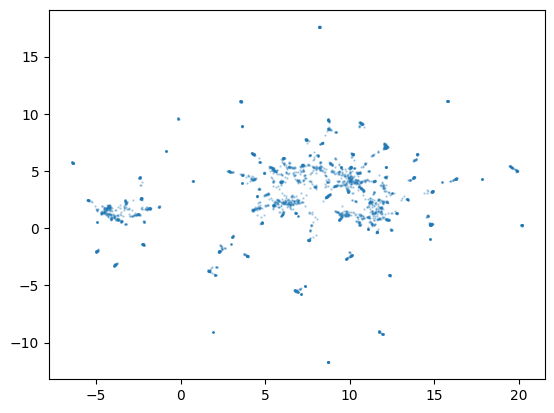

In [34]:
embedding_2d = model.transform(embedding_data)
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=0.5, alpha=0.3)

## UMAP Awesome Prompt Embeddings

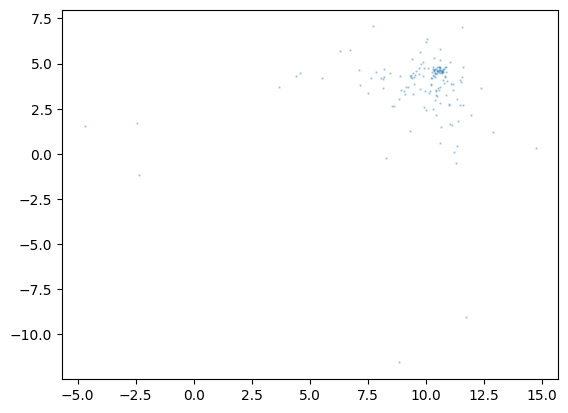

In [76]:
awesome_embeddings_np = np.array(awesome_embeddings)
awesome_embedding_2d = model.transform(awesome_embeddings_np)
plt.scatter(awesome_embedding_2d[:, 0], awesome_embedding_2d[:, 1], s=0.5, alpha=0.3)

## Save Data to WizMap

In [77]:
sentences = []

# Add incident reports
for key in embeddings['reportNumbers']:
    report = f"[{reports[str(key)]['title']}] {reports[str(key)]['text']}"
    sentences.append(report)

# Add awesome prompts
for p in awesome_prompts:
    sentences.append(p)

In [80]:
# Combine embedding points
report_xs = embedding_2d[:, 0].astype(float).tolist()
report_ys = embedding_2d[:, 1].astype(float).tolist()

awesome_xs = awesome_embedding_2d[:, 0].astype(float).tolist()
awesome_ys = awesome_embedding_2d[:, 1].astype(float).tolist()

xs = report_xs + awesome_xs
ys = report_ys + awesome_ys

# Create a label list
labels = [0 for _ in range(len(embeddings["reportNumbers"]))] + [
    1 for _ in range(len(awesome_prompts))
]

In [81]:
data_list = wizmap.generate_data_list(xs, ys, sentences, labels=labels)
grid_dict = wizmap.generate_grid_dict(
    xs,
    ys,
    sentences,
    "AI Incident Reports",
    labels=labels,
    group_names=["Incident", "Prompt"],
)

Start generating data list...
Start generating contours...
Start generating multi-level summaries...


3474it [00:00, 221895.84it/s]
100%|██████████| 6/6 [00:00<00:00,  7.53it/s]


In [85]:
wizmap.save_json_files(data_list, grid_dict, './data/ai-incident')

In [86]:
data_url = 'https://huggingface.co/datasets/xiaohk/embeddings/resolve/main/ai-incident/data.ndjson'
grid_url = 'https://huggingface.co/datasets/xiaohk/embeddings/resolve/main/ai-incident/grid.json'

In [87]:
# Display wizmap
wizmap.visualize(data_url, grid_url)

<iframe
 srcdoc="<!DOCTYPE html><html lang="en"><head><meta charset="UTF-8" /><meta name="viewport" content="width=device-width, initial-scale=1.0" /><title>WizMap</title><style>html {font-size: 16px;-moz-osx-font-smoothing: grayscale;-webkit-font-smoothing: antialiased;text-rendering: optimizeLegibility;-webkit-text-size-adjust: 100%;-moz-text-size-adjust: 100%;scroll-behavior: smooth;}html, body {position: relative;width: 100%;height: 100%;overscroll-behavior: none;}body {margin: 0px;padding: 0px;box-sizing: border-box;font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen-Sans, Ubuntu, Cantarell, 'Helvetica Neue', sans-serif;color: hsl(0, 0%, 29%);font-size: 1em;font-weight: 400;line-height: 1.5;}*, ::after, ::before {box-sizing: inherit;}a {color: rgb(0, 100, 200);text-decoration: none;}a:hover {text-decoration: underline;}a:visited {color: rgb(0, 80, 160);}label {display: block;}input, select, textarea {font-family: inherit;font-size: inherit;-webkit-padding: 0 0;padding: 0;margin: 0 0 0 0;box-sizing: border-box;border: 1px solid #ccc;border-radius: 2px;}input:disabled {color: #ccc;}button {all: unset;outline: none;cursor: pointer;}</style><script defer src='data:text/javascript;base64,dmFyIHdpem1hcD1mdW5jdGlvbigpeyJ1c2Ugc3RyaWN0Ijt2YXIgSGY9T2JqZWN0LmRlZmluZVByb3BlcnR5O3ZhciBUZj0oZWwsUSxvbik9PlEgaW4gZWw/SGYoZWwsUSx7ZW51bWVyYWJsZTohMCxjb25maWd1cmFibGU6ITAsd3JpdGFibGU6ITAsdmFsdWU6b259KTplbFtRXT1vbjt2YXIgYnQ9KGVsLFEsb24pPT4oVGYoZWwsdHlwZW9mIFEhPSJzeW1ib2wiP1ErIiI6USxvbiksb24pO2Z1bmN0aW9uIGVsKCl7fWZ1bmN0aW9uIFEodCxpLGwsZSxuKXt0Ll9fc3ZlbHRlX21ldGE9e2xvYzp7ZmlsZTppLGxpbmU6bCxjb2x1bW46ZSxjaGFyOm59fX1mdW5jdGlvbiBvbih0KXtyZXR1cm4gdCgpfWZ1bmN0aW9uIHUwKCl7cmV0dXJuIE9iamVjdC5jcmVhdGUobnVsbCl9ZnVuY3Rpb24gb2UodCl7dC5mb3JFYWNoKG9uKX1mdW5jdGlvbiBjMCh0KXtyZXR1cm4gdHlwZW9mIHQ9PSJmdW5jdGlvbiJ9ZnVuY3Rpb24gdWQodCxpKXtyZXR1cm4gdCE9dD9pPT1pOnQhPT1pfHx0JiZ0eXBlb2YgdD09Im9iamVjdCJ8fHR5cGVvZiB0PT0iZnVuY3Rpb24ifWZ1bmN0aW9uIEhaKHQpe3JldHVybiBPYmplY3Qua2V5cyh0KS5sZW5ndGg9PT0wfWZ1bmN0aW9uIGEwKHQsaSl7dC5hcHBlbmRDaGlsZChpKX1mdW5jdGlvbiBobyh0LGksbCl7Y29uc3QgZT1UWih0KTtpZighZS5nZXRFbGVtZW50QnlJZChpKSl7Y29uc3Qgbj1FKCJzdHlsZSIpO24uaWQ9aSxuLnRleHRDb250ZW50PWwsa1ooZSxuKX19ZnVuY3Rpb24gVFoodCl7aWYoIXQpcmV0dXJuIGRvY3VtZW50O2NvbnN0IGk9dC5nZXRSb290Tm9kZT90LmdldFJvb3ROb2RlKCk6dC5vd25lckRvY3VtZW50O3JldHVybiBpJiZpLmhvc3Q/aTp0Lm93bmVyRG9jdW1lbnR9ZnVuY3Rpb24ga1oodCxpKXtyZXR1cm4gYTAodC5oZWFkfHx0LGkpLGkuc2hlZXR9ZnVuY3Rpb24gTVoodCxpLGwpe3QuaW5zZXJ0QmVmb3JlKGksbHx8bnVsbCl9ZnVuY3Rpb24gYjAodCl7dC5wYXJlbnROb2RlLnJlbW92ZUNoaWxkKHQpfWZ1bmN0aW9uIHdaKHQsaSl7Zm9yKGxldCBsPTA7bDx0Lmxlbmd0aDtsKz0xKXRbbF0mJnRbbF0uZChpKX1mdW5jdGlvbiBFKHQpe3JldHVybiBkb2N1bWVudC5jcmVhdGVFbGVtZW50KHQpfWZ1bmN0aW9uIG9jKHQpe3JldHVybiBkb2N1bWVudC5jcmVhdGVFbGVtZW50TlMoImh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIix0KX1mdW5jdGlvbiBkbCh0KXtyZXR1cm4gZG9jdW1lbnQuY3JlYXRlVGV4dE5vZGUodCl9ZnVuY3Rpb24gTnQoKXtyZXR1cm4gZGwoIiAiKX1mdW5jdGlvbiB2Wih0LGksbCxlKXtyZXR1cm4gdC5hZGRFdmVudExpc3RlbmVyKGksbCxlKSwoKT0+dC5yZW1vdmVFdmVudExpc3RlbmVyKGksbCxlKX1mdW5jdGlvbiBKWih0LGksbCl7bD09bnVsbD90LnJlbW92ZUF0dHJpYnV0ZShpKTp0LmdldEF0dHJpYnV0ZShpKSE9PWwmJnQuc2V0QXR0cmlidXRlKGksbCl9ZnVuY3Rpb24gTloodCl7cmV0dXJuIEFycmF5LmZyb20odC5jaGlsZE5vZGVzKX1mdW5jdGlvbiBjZCh0LGkpe3QudmFsdWU9aT09bnVsbD8iIjppfWZ1bmN0aW9uIHJpKHQsaSxsKXt0LmNsYXNzTGlzdFtsPyJhZGQiOiJyZW1vdmUiXShpKX1mdW5jdGlvbiB6Wih0LGkse2J1YmJsZXM6bD0hMSxjYW5jZWxhYmxlOmU9ITF9PXt9KXtjb25zdCBuPWRvY3VtZW50LmNyZWF0ZUV2ZW50KCJDdXN0b21FdmVudCIpO3JldHVybiBuLmluaXRDdXN0b21FdmVudCh0LGwsZSxpKSxufWxldCB0cztmdW5jdGlvbiBpcyh0KXt0cz10fWZ1bmN0aW9uIFBaKCl7aWYoIXRzKXRocm93IG5ldyBFcnJvcigiRnVuY3Rpb24gY2FsbGVkIG91dHNpZGUgY29tcG9uZW50IGluaXRpYWxpemF0aW9uIik7cmV0dXJuIHRzfWZ1bmN0aW9uIGFkKHQpe1BaKCkuJCQub25fbW91bnQucHVzaCh0KX1jb25zdCBscz1bXSx1bj1bXSxabz1bXSxtMD1bXSxGWj1Qcm9taXNlLnJlc29sdmUoKTtsZXQgdWM9ITE7ZnVuY3Rpb24galooKXt1Y3x8KHVjPSEwLEZaLnRoZW4ocjApKX1mdW5jdGlvbiBjYyh0KXtaby5wdXNoKHQpfWNvbnN0IGFjPW5ldyBTZXQ7bGV0IEdvPTA7ZnVuY3Rpb24gcjAoKXtjb25zdCB0PXRzO2Rve2Zvcig7R288bHMubGVuZ3RoOyl7Y29uc3QgaT1sc1tHb1

In [72]:
awesome_embeddings_np = np.array(awesome_embeddings)
awesome_embedding_2d = model.transform(awesome_embeddings_np)

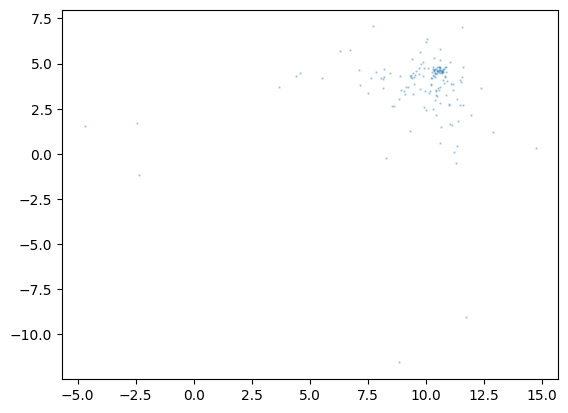